# Color Quantization using K-Means

The original example can be found here: http://scikit-learn.org/stable/auto_examples/cluster/plot_color_quantization.html#sphx-glr-auto-examples-cluster-plot-color-quantization-py

In [1]:
%pylab inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances_argmin
from sklearn.datasets import load_sample_image
from time import time
from sklearn.utils import shuffle
import requests
from PIL import Image
from io import BytesIO
import warnings
warnings.filterwarnings('ignore') # SKLearn is using deprecated methods to load the data

Populating the interactive namespace from numpy and matplotlib


## Load the data

In [2]:
n_colors = 256

# Load the Summer Palace photo
image_url = "https://drwyjmricaxm7.cloudfront.net/blog/wp-content/uploads/2017/01/Temples-shrines-and-castles-in-Japan-social-media-image.jpg"
response = requests.get(image_url)
image = Image.open(BytesIO(response.content))

# Convert to floats instead of the default 8 bits integer coding. Dividing by
# 255 is important so that plt.imshow behaves works well on float data (need to
# be in the range [0-1])
image = np.array(image, dtype=np.float64) / 255

# Load Image and transform to a 2D numpy array.
w, h, d = original_shape = tuple(image.shape)
assert d == 3
image_array = np.reshape(image, (w * h, d))

## Sklearn KMeans on part of the data

In [3]:
%%time
from sklearn.cluster import KMeans
image_array_sample = shuffle(image_array, random_state=0)[:1000]
kmeans_sk_sub = KMeans(n_clusters=n_colors, random_state=0)
kmeans_sk_sub.fit(image_array_sample)
labels_sk_sub = kmeans_sk_sub.predict(image_array)

CPU times: user 12.6 s, sys: 49.6 s, total: 1min 2s
Wall time: 2.93 s


## H2O4GPU KMeans on part of the dataset

In [4]:
from h2o4gpu.util.gpu import get_compute_capability, gpu_info
print(gpu_info())
print(get_compute_capability(0))

(2, 8506769408)
(6, 1, 32)


In [5]:
%%time
from h2o4gpu import KMeans
image_array_sample = shuffle(image_array, random_state=0)[:1000]
kmeans_h2o4gpu_sub = KMeans(n_gpus=1, n_clusters=n_colors, random_state=0)
kmeans_h2o4gpu_sub.fit(image_array_sample)
labels_h2o4gpu_sub = kmeans_h2o4gpu_sub.predict(image_array)

CPU times: user 3.32 s, sys: 384 ms, total: 3.7 s
Wall time: 1.16 s


## Plot the results

In [6]:
def recreate_image(codebook, labels, w, h):
    """Recreate the (compressed) image from the code book & labels"""
    d = codebook.shape[1]
    image = np.zeros((w, h, d))
    label_idx = 0
    for i in range(w):
        for j in range(h):
            image[i][j] = codebook[labels[label_idx]]
            label_idx += 1
    return image

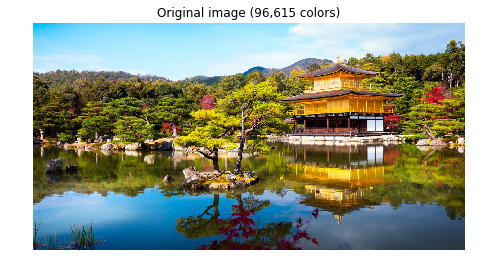

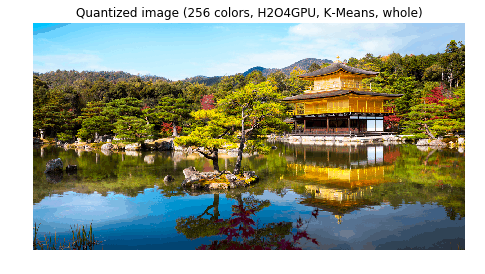

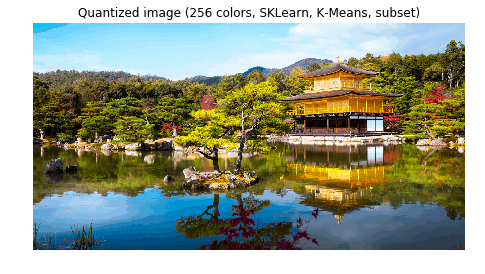

In [7]:
# Display all results, alongside original image
plt.figure(1)
plt.clf()
ax = plt.axes([0, 0, 1, 1])
plt.axis('off')
plt.title('Original image (96,615 colors)')
plt.imshow(image)

plt.figure(2)
plt.clf()
ax = plt.axes([0, 0, 1, 1])
plt.axis('off')
plt.title('Quantized image (256 colors, H2O4GPU, K-Means, whole)')
plt.imshow(recreate_image(kmeans_h2o4gpu_sub.cluster_centers_, labels_h2o4gpu_sub, w, h))

plt.figure(3)
plt.clf()
ax = plt.axes([0, 0, 1, 1])
plt.axis('off')
plt.title('Quantized image (256 colors, SKLearn, K-Means, subset)')
plt.imshow(recreate_image(kmeans_sk_sub.cluster_centers_, labels_sk_sub, w, h))

## H2O4GPU KMeans on the whole dataset

In [8]:
%%time
from h2o4gpu import KMeans
kmeans_h2o4gpu = KMeans(n_gpus=1, n_clusters=n_colors, random_state=0)
kmeans_h2o4gpu.fit(image_array)
labels_h2o4gpu = kmeans_h2o4gpu.labels_

CPU times: user 7.96 s, sys: 684 ms, total: 8.64 s
Wall time: 2.52 s


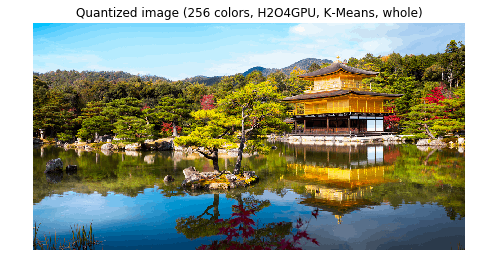

In [10]:
plt.figure(4)
plt.clf()
ax = plt.axes([0, 0, 1, 1])
plt.axis('off')
plt.title('Quantized image (256 colors, H2O4GPU, K-Means, whole)')
plt.imshow(recreate_image(kmeans_h2o4gpu.cluster_centers_, labels_h2o4gpu, w, h))

## Sklearn KMeans on the whole dataset

In [11]:
from sklearn.cluster import KMeans
kmeans_sk = KMeans(n_clusters=n_colors, random_state=0)
%time kmeans_sk.fit(image_array)
%time labels_sk = kmeans_sk.labels_

CPU times: user 38min 9s, sys: 38min 8s, total: 1h 16min 18s
Wall time: 53min 31s
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 11.2 µs


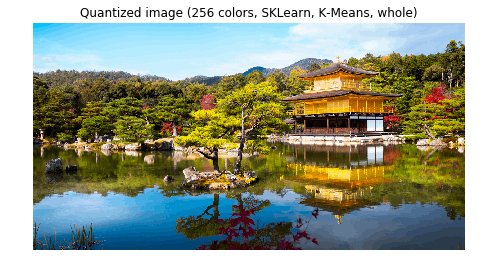

In [12]:
plt.figure(4)
plt.clf()
ax = plt.axes([0, 0, 1, 1])
plt.axis('off')
plt.title('Quantized image (256 colors, SKLearn, K-Means, whole)')
plt.imshow(recreate_image(kmeans_sk.cluster_centers_, labels_sk, w, h))